# Pacbio consensus UMI
This notebook calls consensus muations on PacBio data grouped by by cell_barcode, gene, and UMI. Then, it exports a processed CSV with the following columns:
* cell_barcode
* gene
* UMI
* mutation
* mutation_CCS

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import pandas as pd

import plotnine as p9

In [2]:
UMI_mutations_csv = snakemake.input.UMI_mutations_csv
expt = snakemake.wildcards.expt
consensus_UMI_csv = snakemake.output.consensus_UMI_csv

Style parameters:

In [3]:
p9.theme_set(p9.theme_classic())

## Load Data

In [4]:
UMI_mutations = pd.read_csv(UMI_mutations_csv)
display(UMI_mutations)

,cell_barcode,gene,UMI,mutations,query_name
0,TATTTCGGTGCCTAAT,fluHA,TGGGCGTGAATA,NaN,m64272e_210730_193026/322/ccs
1,TATTTCGGTGCCTAAT,fluHA,ACACGTCCTTGA,NaN,m64272e_210730_193026/620/ccs
2,TGATTTCCATTGCAAC,fluHA,GACGATCTTGGA,T578C,m64272e_210730_193026/1250/ccs
3,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T G1907A ins1907CA G1909A,m64272e_210730_193026/2656/ccs
4,GTCATTTGTCTACACA,fluHA,AATAGAAAGATG,ins495CAA del1014to1014,m64272e_210730_193026/2675/ccs
...,...,...,...,...,...
1179473,AACCAACAGGGTCTTT,fluPB2,ATACTAACTCGA,C812T C1636T,m64272e_210730_193026/180553635/ccs
1179474,CGATGGCCAAAGAGTT,fluPB2,CTAACCAGGGGG,NaN,m64272e_210730_193026/180553782/ccs
1179475,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G del558to2280,m64272e_210730_193026/180553898/ccs
1179476,GCCATTCAGGTGGCTA,fluPB2,GGATTGATCTTT,del1015to2280,m64272e_210730_193026/180554062/ccs


## Process Data

Split each mutation into its own row:

In [5]:
UMI_mutations['muts_split'] = (UMI_mutations['mutations']
                               .apply(lambda x: str(x).split(' ')))
UMI_mutations = UMI_mutations.explode('muts_split')

display(UMI_mutations)

,cell_barcode,gene,UMI,mutations,query_name,muts_split
0,TATTTCGGTGCCTAAT,fluHA,TGGGCGTGAATA,NaN,m64272e_210730_193026/322/ccs,nan
1,TATTTCGGTGCCTAAT,fluHA,ACACGTCCTTGA,NaN,m64272e_210730_193026/620/ccs,nan
2,TGATTTCCATTGCAAC,fluHA,GACGATCTTGGA,T578C,m64272e_210730_193026/1250/ccs,T578C
3,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T G1907A ins1907CA G1909A,m64272e_210730_193026/2656/ccs,C63T
3,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T G1907A ins1907CA G1909A,m64272e_210730_193026/2656/ccs,G1907A
...,...,...,...,...,...,...
1179475,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G del558to2280,m64272e_210730_193026/180553898/ccs,A556G
1179475,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G del558to2280,m64272e_210730_193026/180553898/ccs,del558to2280
1179476,GCCATTCAGGTGGCTA,fluPB2,GGATTGATCTTT,del1015to2280,m64272e_210730_193026/180554062/ccs,del1015to2280
1179477,GTCATTTGTCTACACA,fluPB2,TAAGAACCGAAT,del2221to2280 ins2221TCTAGCATACTTACTGACAGCCAGA...,m64272e_210730_193026/180554193/ccs,del2221to2280


Count total CCS for cell_barcode-gene-UMI and count number of CCS supporting each mutation for cell_barcode-gene-UMI:

In [6]:
mutation_CCS_df = (
    UMI_mutations
    .groupby(['cell_barcode', 'gene', 'UMI', 'muts_split'])
    ['query_name']
    .nunique()
    .reset_index()
    .rename(columns={'query_name': 'mutation_CCS'}))
total_CCS_df = (
    UMI_mutations
    .groupby(['cell_barcode', 'gene', 'UMI'])
    ['query_name']
    .nunique()
    .reset_index()
    .rename(columns={'query_name': 'total_CCS'}))
display(mutation_CCS_df)
display(total_CCS_df)

,cell_barcode,gene,UMI,muts_split,mutation_CCS
0,AAACGAAGTACTTCCC,fluM,AAAAAGACGGAA,nan,1
1,AAACGAAGTACTTCCC,fluM,AAAAATACTACG,A623G,1
2,AAACGAAGTACTTCCC,fluM,AAAAATTAATGC,nan,1
3,AAACGAAGTACTTCCC,fluM,AAAACAAATATA,T451C,1
4,AAACGAAGTACTTCCC,fluM,AAAACAAATATA,del969to980,1
...,...,...,...,...,...
1276793,TTTGGAGGTATCGTTG,fluPB2,TATGATCTAGGG,C1865T,1
1276794,TTTGGAGGTATCGTTG,fluPB2,TATGATCTAGGG,del1126to1755,1
1276795,TTTGGAGGTATCGTTG,fluPB2,TATGATCTAGGG,del17to17,1
1276796,TTTGGAGGTATCGTTG,fluPB2,TATGATCTAGGG,ins504C,1


,cell_barcode,gene,UMI,total_CCS
0,AAACGAAGTACTTCCC,fluM,AAAAAGACGGAA,1
1,AAACGAAGTACTTCCC,fluM,AAAAATACTACG,1
2,AAACGAAGTACTTCCC,fluM,AAAAATTAATGC,1
3,AAACGAAGTACTTCCC,fluM,AAAACAAATATA,1
4,AAACGAAGTACTTCCC,fluM,AAAAGTCGTGGT,1
...,...,...,...,...
549150,TTTGGAGGTATCGTTG,fluPB2,CTATCCGTTCTT,7
549151,TTTGGAGGTATCGTTG,fluPB2,GTGATTCATGAA,1
549152,TTTGGAGGTATCGTTG,fluPB2,TAATCAACAAGG,6
549153,TTTGGAGGTATCGTTG,fluPB2,TAGTTTACACGT,2


Merge into UMI_mutations df:

In [7]:
UMI_mutations = pd.merge(
    left=UMI_mutations,
    right=mutation_CCS_df,
    on=['cell_barcode', 'gene', 'UMI', 'muts_split'],
    how='left',
    validate='many_to_one'
)
UMI_mutations = pd.merge(
    left=UMI_mutations,
    right=total_CCS_df,
    on=['cell_barcode', 'gene', 'UMI'],
    how='left',
    validate='many_to_one'
)
display(UMI_mutations)

,cell_barcode,gene,UMI,mutations,query_name,muts_split,mutation_CCS,total_CCS
0,TATTTCGGTGCCTAAT,fluHA,TGGGCGTGAATA,NaN,m64272e_210730_193026/322/ccs,nan,1,1
1,TATTTCGGTGCCTAAT,fluHA,ACACGTCCTTGA,NaN,m64272e_210730_193026/620/ccs,nan,1,1
2,TGATTTCCATTGCAAC,fluHA,GACGATCTTGGA,T578C,m64272e_210730_193026/1250/ccs,T578C,1,1
3,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T G1907A ins1907CA G1909A,m64272e_210730_193026/2656/ccs,C63T,1,1
4,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T G1907A ins1907CA G1909A,m64272e_210730_193026/2656/ccs,G1907A,1,1
...,...,...,...,...,...,...,...,...
1804385,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G del558to2280,m64272e_210730_193026/180553898/ccs,A556G,2,2
1804386,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G del558to2280,m64272e_210730_193026/180553898/ccs,del558to2280,2,2
1804387,GCCATTCAGGTGGCTA,fluPB2,GGATTGATCTTT,del1015to2280,m64272e_210730_193026/180554062/ccs,del1015to2280,3,4
1804388,GTCATTTGTCTACACA,fluPB2,TAAGAACCGAAT,del2221to2280 ins2221TCTAGCATACTTACTGACAGCCAGA...,m64272e_210730_193026/180554193/ccs,del2221to2280,5,13


Calculate fraction of total CCS with mutation:

In [8]:
UMI_mutations['frac_CCS'] = (
    UMI_mutations['mutation_CCS'] /
    UMI_mutations['total_CCS']
)
display(UMI_mutations)

,cell_barcode,gene,UMI,mutations,query_name,muts_split,mutation_CCS,total_CCS,frac_CCS
0,TATTTCGGTGCCTAAT,fluHA,TGGGCGTGAATA,NaN,m64272e_210730_193026/322/ccs,nan,1,1,1.000000
1,TATTTCGGTGCCTAAT,fluHA,ACACGTCCTTGA,NaN,m64272e_210730_193026/620/ccs,nan,1,1,1.000000
2,TGATTTCCATTGCAAC,fluHA,GACGATCTTGGA,T578C,m64272e_210730_193026/1250/ccs,T578C,1,1,1.000000
3,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T G1907A ins1907CA G1909A,m64272e_210730_193026/2656/ccs,C63T,1,1,1.000000
4,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T G1907A ins1907CA G1909A,m64272e_210730_193026/2656/ccs,G1907A,1,1,1.000000
...,...,...,...,...,...,...,...,...,...
1804385,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G del558to2280,m64272e_210730_193026/180553898/ccs,A556G,2,2,1.000000
1804386,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G del558to2280,m64272e_210730_193026/180553898/ccs,del558to2280,2,2,1.000000
1804387,GCCATTCAGGTGGCTA,fluPB2,GGATTGATCTTT,del1015to2280,m64272e_210730_193026/180554062/ccs,del1015to2280,3,4,0.750000
1804388,GTCATTTGTCTACACA,fluPB2,TAAGAACCGAAT,del2221to2280 ins2221TCTAGCATACTTACTGACAGCCAGA...,m64272e_210730_193026/180554193/ccs,del2221to2280,5,13,0.384615


## Call consensus
Label consensus mutations if found in >50% of CCS. This corresponds to `frac_CCS > 0.5` in our dataframe.

In [9]:
UMI_mutations['consensus'] = (
    UMI_mutations['frac_CCS'] > 0.5
)
display(UMI_mutations)

,cell_barcode,gene,UMI,mutations,query_name,muts_split,mutation_CCS,total_CCS,frac_CCS,consensus
0,TATTTCGGTGCCTAAT,fluHA,TGGGCGTGAATA,NaN,m64272e_210730_193026/322/ccs,nan,1,1,1.000000,True
1,TATTTCGGTGCCTAAT,fluHA,ACACGTCCTTGA,NaN,m64272e_210730_193026/620/ccs,nan,1,1,1.000000,True
2,TGATTTCCATTGCAAC,fluHA,GACGATCTTGGA,T578C,m64272e_210730_193026/1250/ccs,T578C,1,1,1.000000,True
3,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T G1907A ins1907CA G1909A,m64272e_210730_193026/2656/ccs,C63T,1,1,1.000000,True
4,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T G1907A ins1907CA G1909A,m64272e_210730_193026/2656/ccs,G1907A,1,1,1.000000,True
...,...,...,...,...,...,...,...,...,...,...
1804385,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G del558to2280,m64272e_210730_193026/180553898/ccs,A556G,2,2,1.000000,True
1804386,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G del558to2280,m64272e_210730_193026/180553898/ccs,del558to2280,2,2,1.000000,True
1804387,GCCATTCAGGTGGCTA,fluPB2,GGATTGATCTTT,del1015to2280,m64272e_210730_193026/180554062/ccs,del1015to2280,3,4,0.750000,True
1804388,GTCATTTGTCTACACA,fluPB2,TAAGAACCGAAT,del2221to2280 ins2221TCTAGCATACTTACTGACAGCCAGA...,m64272e_210730_193026/180554193/ccs,del2221to2280,5,13,0.384615,False


## Plot outcomes

Plot distribution of total CCS per cell_barcode-gene-UMI:

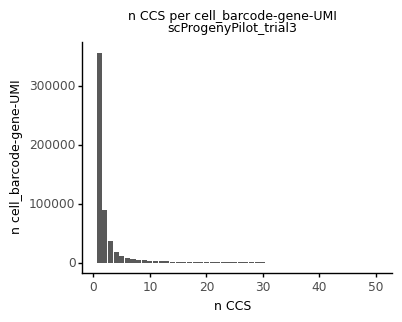

<ggplot: (8757908829139)>

In [10]:
total_CCS_histo = (
    p9.ggplot(
        (UMI_mutations
         [['cell_barcode', 'gene', 'UMI', 'total_CCS']]
         .drop_duplicates()),
         p9.aes(x='total_CCS')) +
    p9.geom_histogram(stat='count') +
    p9.ggtitle('n CCS per cell_barcode-gene-UMI\n'
               f'{expt}') +
    p9.labs(x='n CCS',
            y='n cell_barcode-gene-UMI') +
    p9.theme(figure_size=(4, 3),
             plot_title=p9.element_text(size=9),
             axis_title=p9.element_text(size=9),
             legend_title=p9.element_text(size=9),
             legend_title_align='center'))

display(total_CCS_histo)

Plot distribution of CCS per mutation:

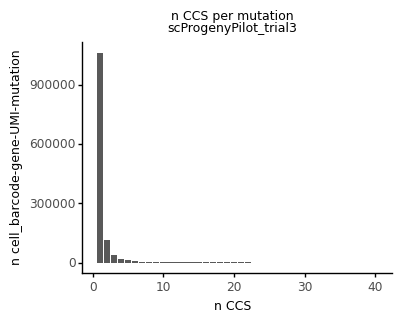

<ggplot: (8757930818527)>

In [11]:
mutation_CCS_histo = (
    p9.ggplot(
        (UMI_mutations
         [['cell_barcode', 'gene', 'UMI', 'muts_split', 'mutation_CCS']]
         .drop_duplicates()),
         p9.aes(x='mutation_CCS')) +
    p9.geom_histogram(stat='count') +
    p9.ggtitle('n CCS per mutation\n'
               f'{expt}') +
    p9.labs(x='n CCS',
            y='n cell_barcode-gene-UMI-mutation') +
    p9.theme(figure_size=(4, 3),
             plot_title=p9.element_text(size=9),
             axis_title=p9.element_text(size=9),
             legend_title=p9.element_text(size=9),
             legend_title_align='center'))

display(mutation_CCS_histo)

Plot relationship between the two:

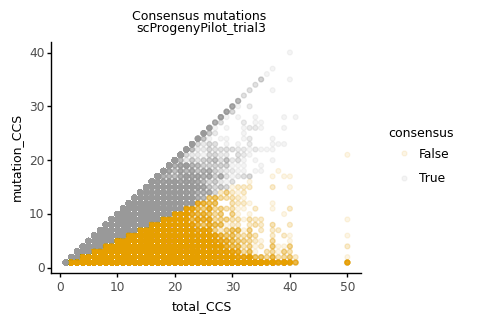

<ggplot: (8757909686848)>

In [12]:
consensus_mutations_scatter = (
    p9.ggplot(
        (UMI_mutations
         [['cell_barcode', 'gene', 'UMI', 'muts_split', 'mutation_CCS', 'total_CCS', 'consensus']]
         .drop_duplicates()),
         p9.aes(x='total_CCS',
                y='mutation_CCS',
                color='consensus')) +
    p9.geom_point(alpha=0.1) +
    p9.ggtitle('Consensus mutations \n'
               f'{expt}') +
    p9.theme(figure_size=(4, 3),
             plot_title=p9.element_text(size=9),
             axis_title=p9.element_text(size=9),
             legend_title=p9.element_text(size=9),
             legend_title_align='center') +
    p9.scale_color_manual([CBPALETTE[1], CBPALETTE[0]]))

display(consensus_mutations_scatter)

In [13]:
output_df = (
    UMI_mutations
    .query('consensus==True')
    [['cell_barcode', 'gene', 'UMI', 'muts_split']]
    .rename(columns={'muts_split': 'mutation'})
)
display(output_df)

print(f'Saving UMI consensus mutations to {consensus_UMI_csv}')
output_df.to_csv(consensus_UMI_csv, index=False)

,cell_barcode,gene,UMI,mutation
0,TATTTCGGTGCCTAAT,fluHA,TGGGCGTGAATA,nan
1,TATTTCGGTGCCTAAT,fluHA,ACACGTCCTTGA,nan
2,TGATTTCCATTGCAAC,fluHA,GACGATCTTGGA,T578C
3,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,C63T
4,GTCGTTCTCGTTTACT,fluHA,ATTCTAGGGGTC,G1907A
...,...,...,...,...
1804381,ATTCCATAGTTAGTAG,fluPB2,AAGGAACATTCG,del558to2280
1804384,CGATGGCCAAAGAGTT,fluPB2,CTAACCAGGGGG,nan
1804385,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,A556G
1804386,GTAGAAACACCTAAAC,fluPB2,ATGGAGCCGTGA,del558to2280


Saving UMI consensus mutations to consensus_UMI.csv.gz
